In [3]:
import numpy as np
import pandas as pd
from typing import List, Tuple
from tqdm import tqdm
tqdm.pandas()

import umap.umap_ as umap
import umap.plot
import umap.aligned_umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetMACCSKeysFingerprint

import torch
import yaml
from argparse import Namespace
from fast_transformers.masking import LengthMask as LM
import sys
import os
import plotly.express as px

notebook_directory = os.getcwd()
molformer_directory = os.path.join(notebook_directory, "..")
sys.path.append(molformer_directory)
from MolFormer.finetune.tokenizer.tokenizer import MolTranBertTokenizer
from MolFormer.training.train_pubchem_light import LightningModule

/Users/paulina_koerner/Desktop/MasterThesis/molformer_venv/lib/python3.11/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [4]:

def create_manifold(
    df: pd.DataFrame, 
    n_components: int,
    n_neighbors: int, 
    min_dist: float,
    metric: str,
    random_state: int,
    target_weight: float,
    supervised: bool,
) -> Tuple[umap.umap_.UMAP, np.ndarray]:
    x, y, y_str = df.drop(["label", "label_str"], axis=1), df[["label"]].values.flatten(), df[["label_str"]].values.flatten()
    y_encoded = pd.factorize(y)[0]
    if supervised:
        manifold = umap.UMAP(
            n_components=n_components, 
            n_neighbors=n_neighbors, 
            min_dist=min_dist, 
            metric=metric, 
            random_state=random_state, 
            n_jobs=1,
            target_weight=target_weight,
        ).fit(x, y_encoded)
    else: 
        manifold = umap.UMAP(
            n_components=n_components, 
            n_neighbors=n_neighbors, 
            min_dist=min_dist, 
            metric=metric, 
            random_state=random_state, 
            n_jobs=1,
        ).fit(x)
    return manifold, y_str

def load_checkpoint():
    with open("MoLFormer/data/Pretrained MoLFormer/hparams.yaml", "r") as f:
        config = Namespace(**yaml.safe_load(f))
    tokenizer = MolTranBertTokenizer("MoLFormer/training/bert_vocab.txt")
    ckpt = "MoLFormer/data/Pretrained MoLFormer/checkpoints/N-Step-Checkpoint_3_30000.ckpt"
    lm = LightningModule(config, tokenizer.vocab).load_from_checkpoint(ckpt, config=config, vocab=tokenizer.vocab)
    return tokenizer, lm

def batch_split(data, batch_size=64):
    i = 0
    while i < len(data):
        yield data[i : min(i + batch_size, len(data))]
        i += batch_size

def get_embeddings(model, smiles, tokenizer, batch_size=64):
    model.eval()
    embeddings = []
    with tqdm(total=len(smiles), desc="Getting embeddings from MolFormer", ncols=100) as pbar:
        for batch in batch_split(smiles, batch_size=batch_size):
            batch_enc = tokenizer.batch_encode_plus(batch, padding=True, add_special_tokens=True)
            idx, mask = torch.tensor(batch_enc["input_ids"]), torch.tensor(batch_enc["attention_mask"])
            with torch.no_grad():
                token_embeddings = model.blocks(model.tok_emb(idx), length_mask=LM(mask.sum(-1)))
            # average pooling over tokens
            input_mask_expanded = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            embedding = sum_embeddings / sum_mask
            embeddings.append(embedding.detach().cpu())
            pbar.update(len(batch))
    return torch.cat(embeddings)

def create_features_molformer(df: pd.DataFrame, tokenizer, lm) -> pd.DataFrame:
    def canonicalize(s):
        return Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True, isomericSmiles=False)
    smiles = df.smiles.apply(canonicalize)
    embeddings = get_embeddings(lm, smiles, tokenizer).numpy()
    df = df.copy()
    df["fingerprint"] = [embedding.tolist() for embedding in embeddings]
    return df

def convert_to_maccs_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
    fp_vecs = [GetMACCSKeysFingerprint(mol) for mol in mols]
    fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
    df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
    return df

def convert_to_morgan_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
    fp_vecs = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mols]
    fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
    df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
    return df

def convert_to_rdk_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
    fp_vecs = [Chem.RDKFingerprint(mol) for mol in mols]
    fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
    df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
    return df


def create_dfs_from_final_and_removed(df: pd.DataFrame, df_removed: pd.DataFrame, final: bool, feature_type: str) -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
]:
    if feature_type == "MACCS":
        size = 167
        df = convert_to_maccs_fingerprints(df=df)
        df_removed = convert_to_maccs_fingerprints(df=df_removed)
    elif feature_type == "Morgan":
        size = 1024
        df = convert_to_morgan_fingerprints(df=df)
        df_removed = convert_to_morgan_fingerprints(df=df_removed)
    elif feature_type == "RDK":
        size = 2048
        df = convert_to_rdk_fingerprints(df=df)
        df_removed = convert_to_rdk_fingerprints(df=df_removed)
    elif feature_type == "Molformer":
        size = 768
        tokenizer, lm = load_checkpoint()
        df = create_features_molformer(df=df, tokenizer=tokenizer, lm=lm)
        df_removed = create_features_molformer(df=df_removed, tokenizer=tokenizer, lm=lm)
    
    if final: 
        curated = "$Curated_{Final}$"
        removed = "$Curated_{Removed}$"
    else: 
        curated = "$Curated_{BIOWIN}$"
        removed = "$Curated_{Problematic}$"
    
    cols = [*range(0, size, 1)]
    df_fp = pd.DataFrame(df.fingerprint.tolist(), columns=cols)
    df_removed_fp = pd.DataFrame(df_removed.fingerprint.tolist(), columns=cols)
    
    df_removed_labeled = pd.DataFrame(df_removed.fingerprint.tolist(), columns=cols)
    df_removed_labeled["label"] = df_removed['label']
    df_removed_labeled["label_str"] = df_removed_labeled["label"].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    df_fp["label"] = curated
    df_removed_fp["label"] = removed
    df_removed_labels = pd.concat([df_fp, df_removed_fp], axis=0)
    df_removed_labels["label_str"] = df_removed_labels['label']

    df_fp["label"] = df["label"]
    df_removed_fp["label"] = df_removed['label']
    df_all = pd.concat([df_fp, df_removed_fp], axis=0)
    df_all["label_str"] = df_all['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    df_fp["label"] = df["label"]
    df_removed_fp["label"] = df_removed['label'] + 2
    df_four_labels = pd.concat([df_fp, df_removed_fp], axis=0)
    df_four_labels["label_str"] = df_four_labels['label'].map({0: f"{curated} NRB", 1: f"{curated} RB", 2: f"{removed} NRB", 3: f"{removed} RB"})

    df_removed_fp["label"] = df_removed['label']
    df_four_colors = pd.concat([df_fp, df_removed_fp], axis=0)
    df_four_colors["label_str"] = df_four_labels['label_str']

    df_fp_labeled = pd.DataFrame(df.fingerprint.tolist(), columns=cols)
    df_fp_labeled["label"] = df["label"]
    df_fp_labeled["label_str"] = df_fp_labeled['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # semisupervised
    df_removed_fp["label"] = -1
    df_semi_supervised = pd.concat([df_fp, df_removed_fp], axis=0)
    df_semi_supervised["label_str"] = df_four_labels['label_str']

    return df_removed_labels, df_all, df_four_labels, df_four_colors, df_fp_labeled, df_semi_supervised, df_removed_labeled
    

def create_dfs_biowin_umap(feature_type: str) -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame,
]:
    df_biowin = pd.read_csv("datasets/curated_data/class_curated_biowin.csv", index_col=0)
    df_biowin = df_biowin[['cas', 'smiles','inchi_from_smiles', 'label', 'linear_label',
        'non_linear_label', 'miti_linear_label', 'miti_non_linear_label']]
    df_biowin.reset_index(inplace=True, drop=True)
    df_problematic = pd.read_csv("datasets/curated_data/class_curated_biowin_problematic.csv", index_col=0)
    df_problematic.reset_index(inplace=True, drop=True)
    return create_dfs_from_final_and_removed(df=df_biowin, df_removed=df_problematic, final=False, feature_type=feature_type)


def create_dfs_final_umap(feature_type: str) -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame,
]:
    df_final = pd.read_csv("datasets/curated_data/class_curated_final.csv", index_col=0)
    df_final = df_final[['cas', 'smiles','inchi_from_smiles', 'label', 'linear_label',
        'non_linear_label', 'miti_linear_label', 'miti_non_linear_label']]
    df_final.reset_index(inplace=True, drop=True)
    df_removed = pd.read_csv("datasets/curated_data/class_curated_final_removed.csv", index_col=0)
    df_removed["label"] = df_removed["y_true"]
    df_removed.reset_index(inplace=True, drop=True)
    return create_dfs_from_final_and_removed(df=df_final, df_removed=df_removed, final=True, feature_type=feature_type)


def create_plot(
    manifolds: List[umap.umap_.UMAP], 
    y_strs: List[np.ndarray], 
    titles: List[str], 
    legend_loc: List[str], 
    number_of_labels: List[int],
    figure_title: str,
    final: List[bool],
) -> None:

    _, axs = plt.subplots(2, 3, figsize=(30, 20))

    for i, ax in enumerate(axs.flatten()):
        label=y_strs[i]
        final_cur = final[i]

        if final_cur: 
            curated = "$Curated_{Final}$"
            removed = "$Curated_{Removed}$"
        else: 
            curated = "$Curated_{BIOWIN}$"
            removed = "$Curated_{Problematic}$"
    
        if ('NRB' in label[0]) | ('RB' in label[0]):
            color_key={
                f"{curated} NRB": 'royalblue', 
                f"{removed} NRB": 'limegreen', 
                f"{curated} RB": 'darkorange', 
                f"{removed} RB": 'fuchsia'} 
        else: 
            if final_cur:
                color_key={
                    curated: 'green', 
                    removed: 'gold'}
            else: 
                color_key={
                    curated: 'forestgreen', 
                    removed: 'yellow'}
        
        umap.plot.points(
            umap_object=manifolds[i], 
            labels=label, 
            color_key=color_key,
            background='black',
            ax=ax,
        ) 
        ax.set_xlabel(titles[i], fontsize=22)
        nrb = mpatches.Patch(color='royalblue', label=f"{curated} NRB")
        rb = mpatches.Patch(color='darkorange', label=f"{curated} RB")
        if number_of_labels[i] == 4:
            nrb_r = mpatches.Patch(color='limegreen', label=f"{removed} NRB")
            rb_r = mpatches.Patch(color='fuchsia', label=f"{removed} RB")
            ax.legend(loc=legend_loc[i], handles=[nrb, rb, nrb_r, rb_r], fontsize=16)
        elif ('NRB' not in label[0]) & ('RB' not in label[0]):
            if final_cur:
                cb = mpatches.Patch(color='green', label=curated)
                cr = mpatches.Patch(color='gold', label=removed)
            else: 
                cb = mpatches.Patch(color='forestgreen', label=curated)
                cr = mpatches.Patch(color='yellow', label=removed)
            ax.legend(loc=legend_loc[i], handles=[cb, cr], fontsize=16)
        else:
            ax.legend(loc=legend_loc[i], handles=[nrb, rb], fontsize=16)
        umap.plot.plt.savefig(f'figures/{figure_title}.png')


In [5]:
def create_plot_umap_semisupervised(
    n_components, 
    n_neighbors, 
    min_dist, 
    target_weight, 
    metric, 
    random_state,
    feature_type,
    legend_loc,
) -> None:

    # Biowin
    df_removed_labels_biowin, _, df_four_labels_biowin, _, _, df_semi_supervised_biowin, _ = create_dfs_biowin_umap(feature_type=feature_type)

    manifold_unsupervised_removed, y_unsupervised_str_removed = create_manifold(
        df=df_removed_labels_biowin, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_unsupervised, y_unsupervised_str = create_manifold(
        df=df_four_labels_biowin, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_semi_supervised, y_semi_supervised_str = create_manifold(
        df=df_semi_supervised_biowin, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=True,
    )

    # Final
    df_removed_labels_final, _, df_four_labels_final, _, _, df_semi_supervised_final, _ = create_dfs_final_umap(feature_type=feature_type)

    manifold_unsupervised_removed_final, y_unsupervised_str_removed_final = create_manifold(
        df=df_removed_labels_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_unsupervised_final, y_unsupervised_str_final = create_manifold(
        df=df_four_labels_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_semi_supervised_final, y_semi_supervised_str_final = create_manifold(
        df=df_semi_supervised_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=True,
    )

    # Create plot
    manifolds = [
        manifold_unsupervised_removed,
        manifold_unsupervised,
        manifold_semi_supervised, 
        manifold_unsupervised_removed_final,
        manifold_unsupervised_final,
        manifold_semi_supervised_final 
    ]
    y_strs = [
        y_unsupervised_str_removed,
        y_unsupervised_str,
        y_semi_supervised_str,
        y_unsupervised_str_removed_final,
        y_unsupervised_str_final,
        y_semi_supervised_str_final,
    ]

    titles = [
        'a) $Curated_{BIOWIN}$ + $Curated_{Problematic}$ \n unsupervised',
        'b) $Curated_{BIOWIN}$ + $Curated_{Problematic}$ \n unsupervised with labels',
        'c) $Curated_{BIOWIN}$ + $Curated_{Problematic}$ \n semi-supervised' + f'(target_weight={target_weight})',
        'd) $Curated_{Final}$ + $Curated_{Removed}$ \n unsupervised',
        'e) $Curated_{Final}$ + $Curated_{Removed}$ \n  unsupervised with labels',
        'f) $Curated_{Final}$ + $Curated_{Removed}$ \n  semi-supervised ' + f'(target_weight={target_weight})',
    ]
    number_of_labels = [2, 4, 4, 2, 4, 4]

    create_plot(
        manifolds=manifolds, 
        y_strs=y_strs, 
        titles=titles, 
        legend_loc=legend_loc, 
        number_of_labels=number_of_labels,
        figure_title=f"umap_semisupervised_{feature_type}",
        final=[False, False, False, True, True, True]
    )

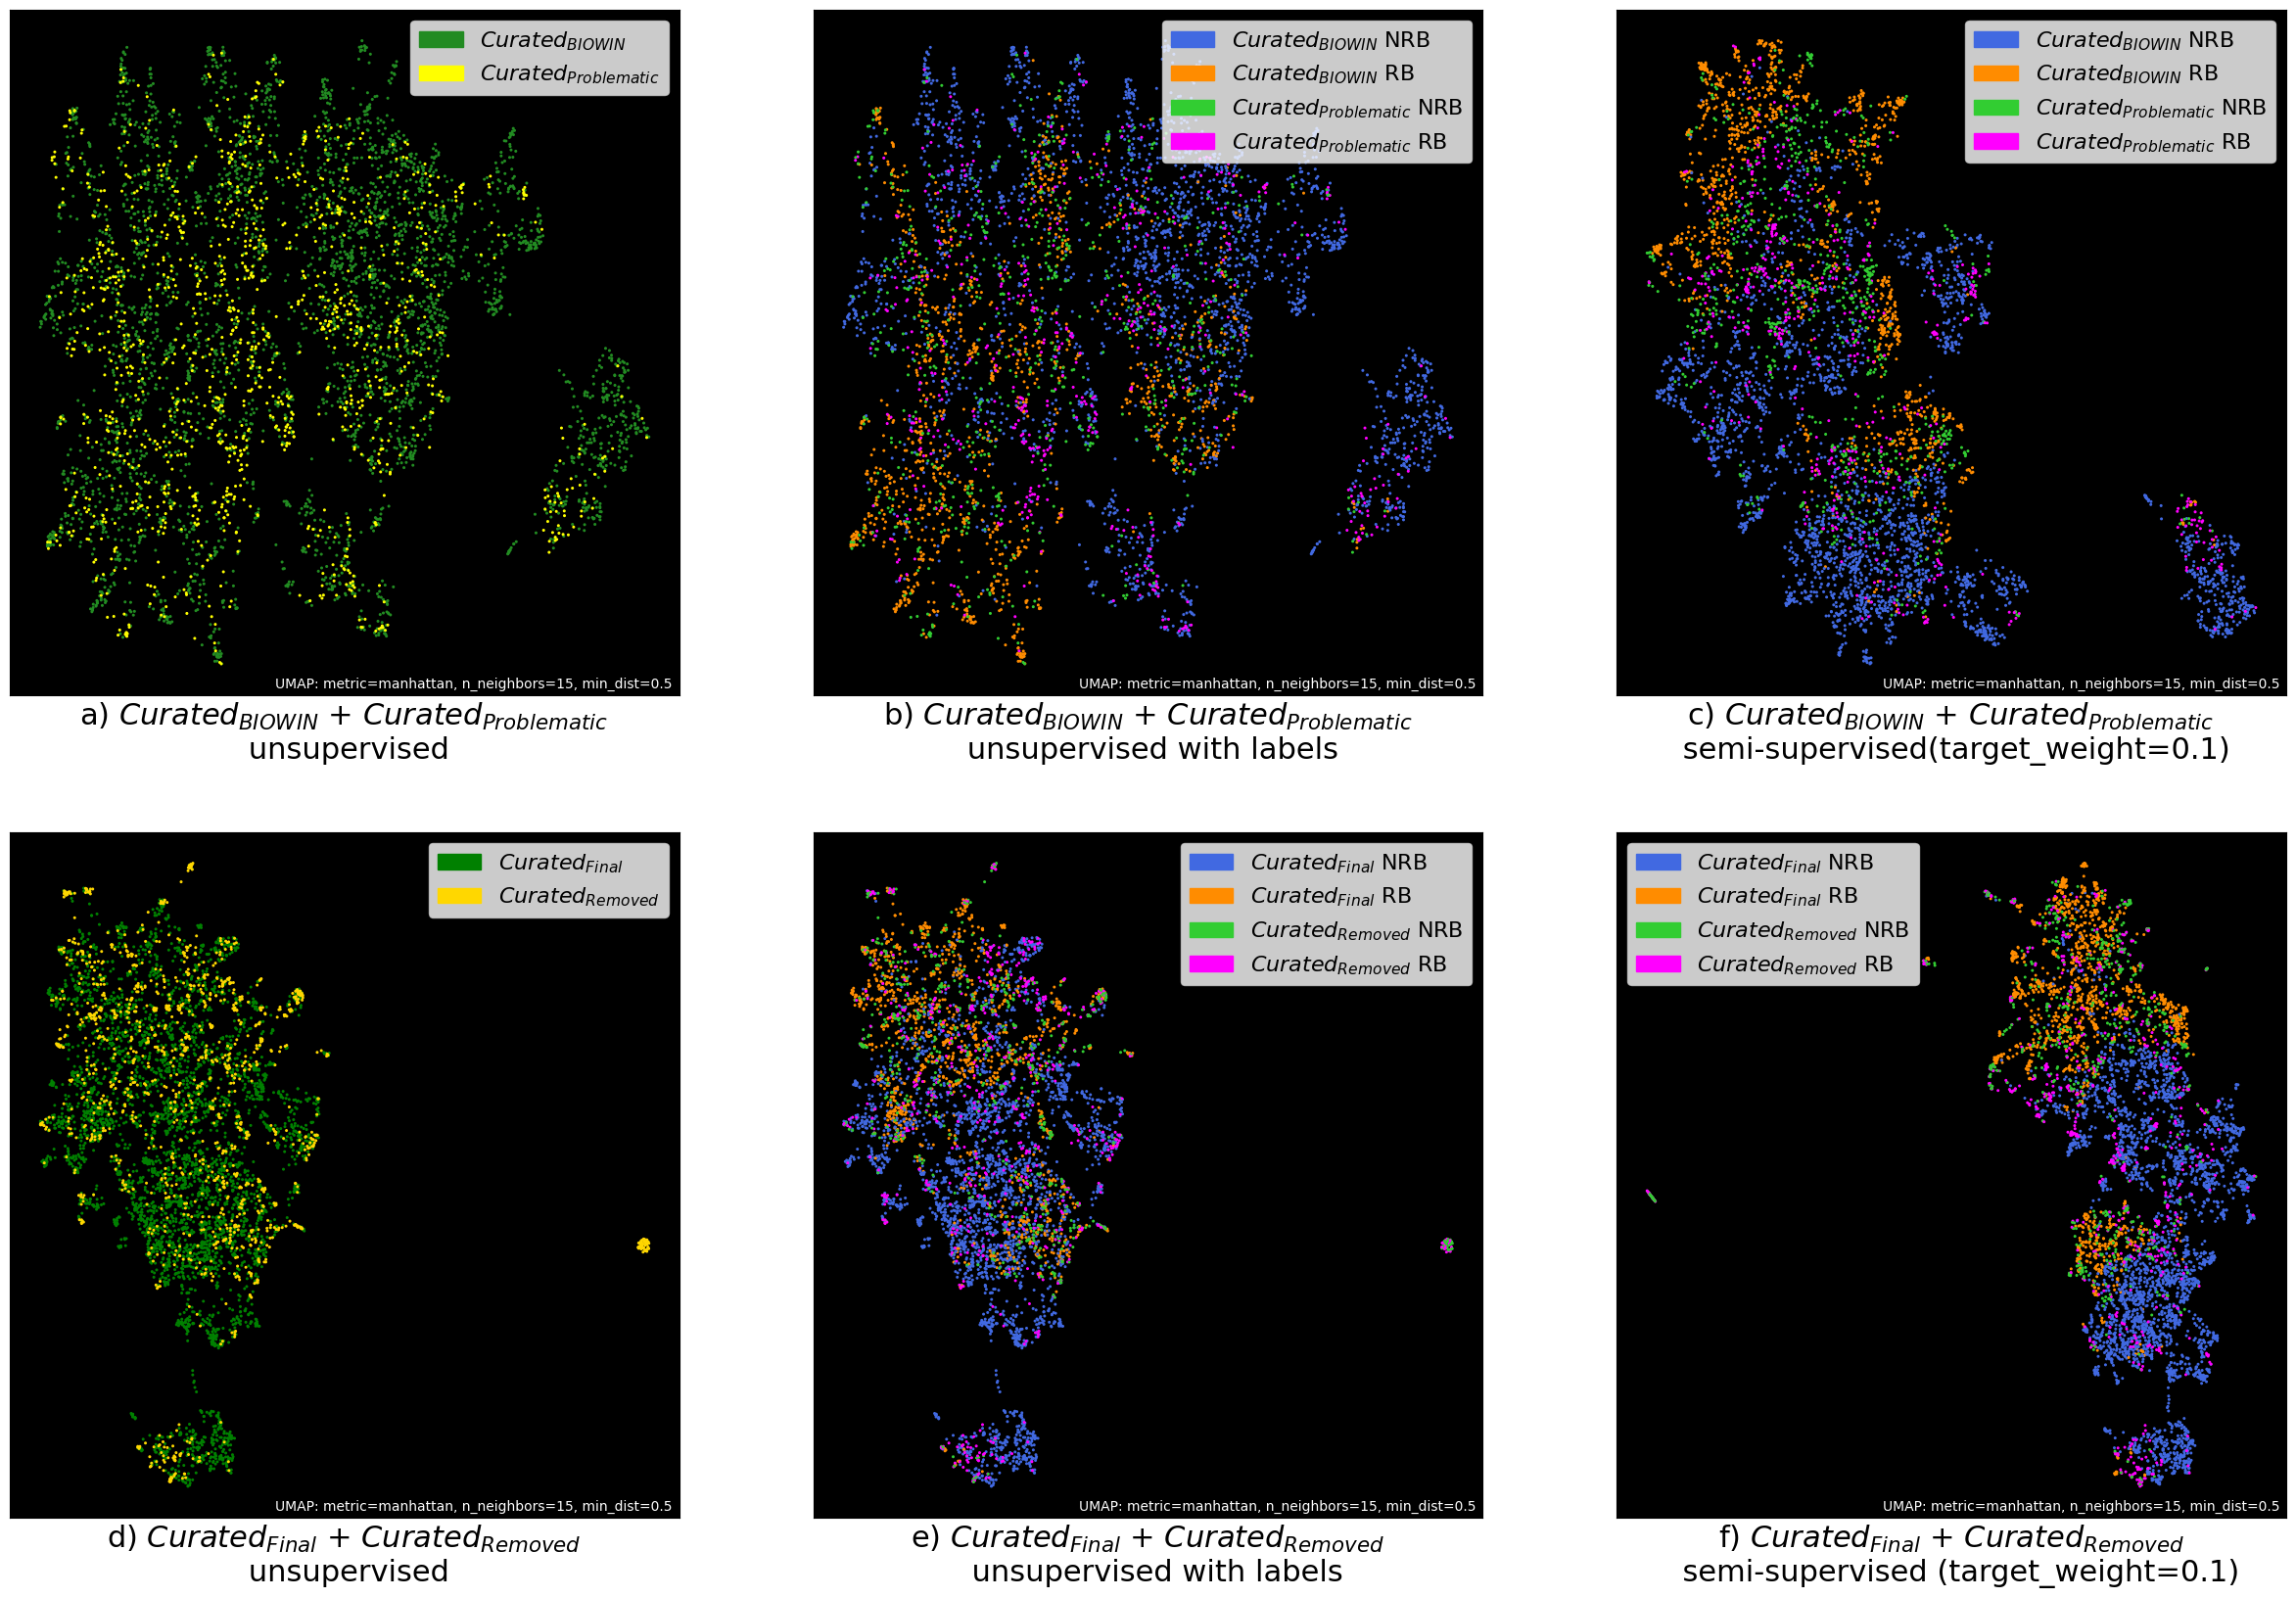

In [4]:
create_plot_umap_semisupervised(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.5, 
    target_weight=0.1, 
    metric="manhattan", 
    random_state=42,
    feature_type="MACCS",
    legend_loc=[
        'upper right',
        'upper right',
        'upper right',
        'upper right',
        'upper right',
        'upper left',
    ],
)

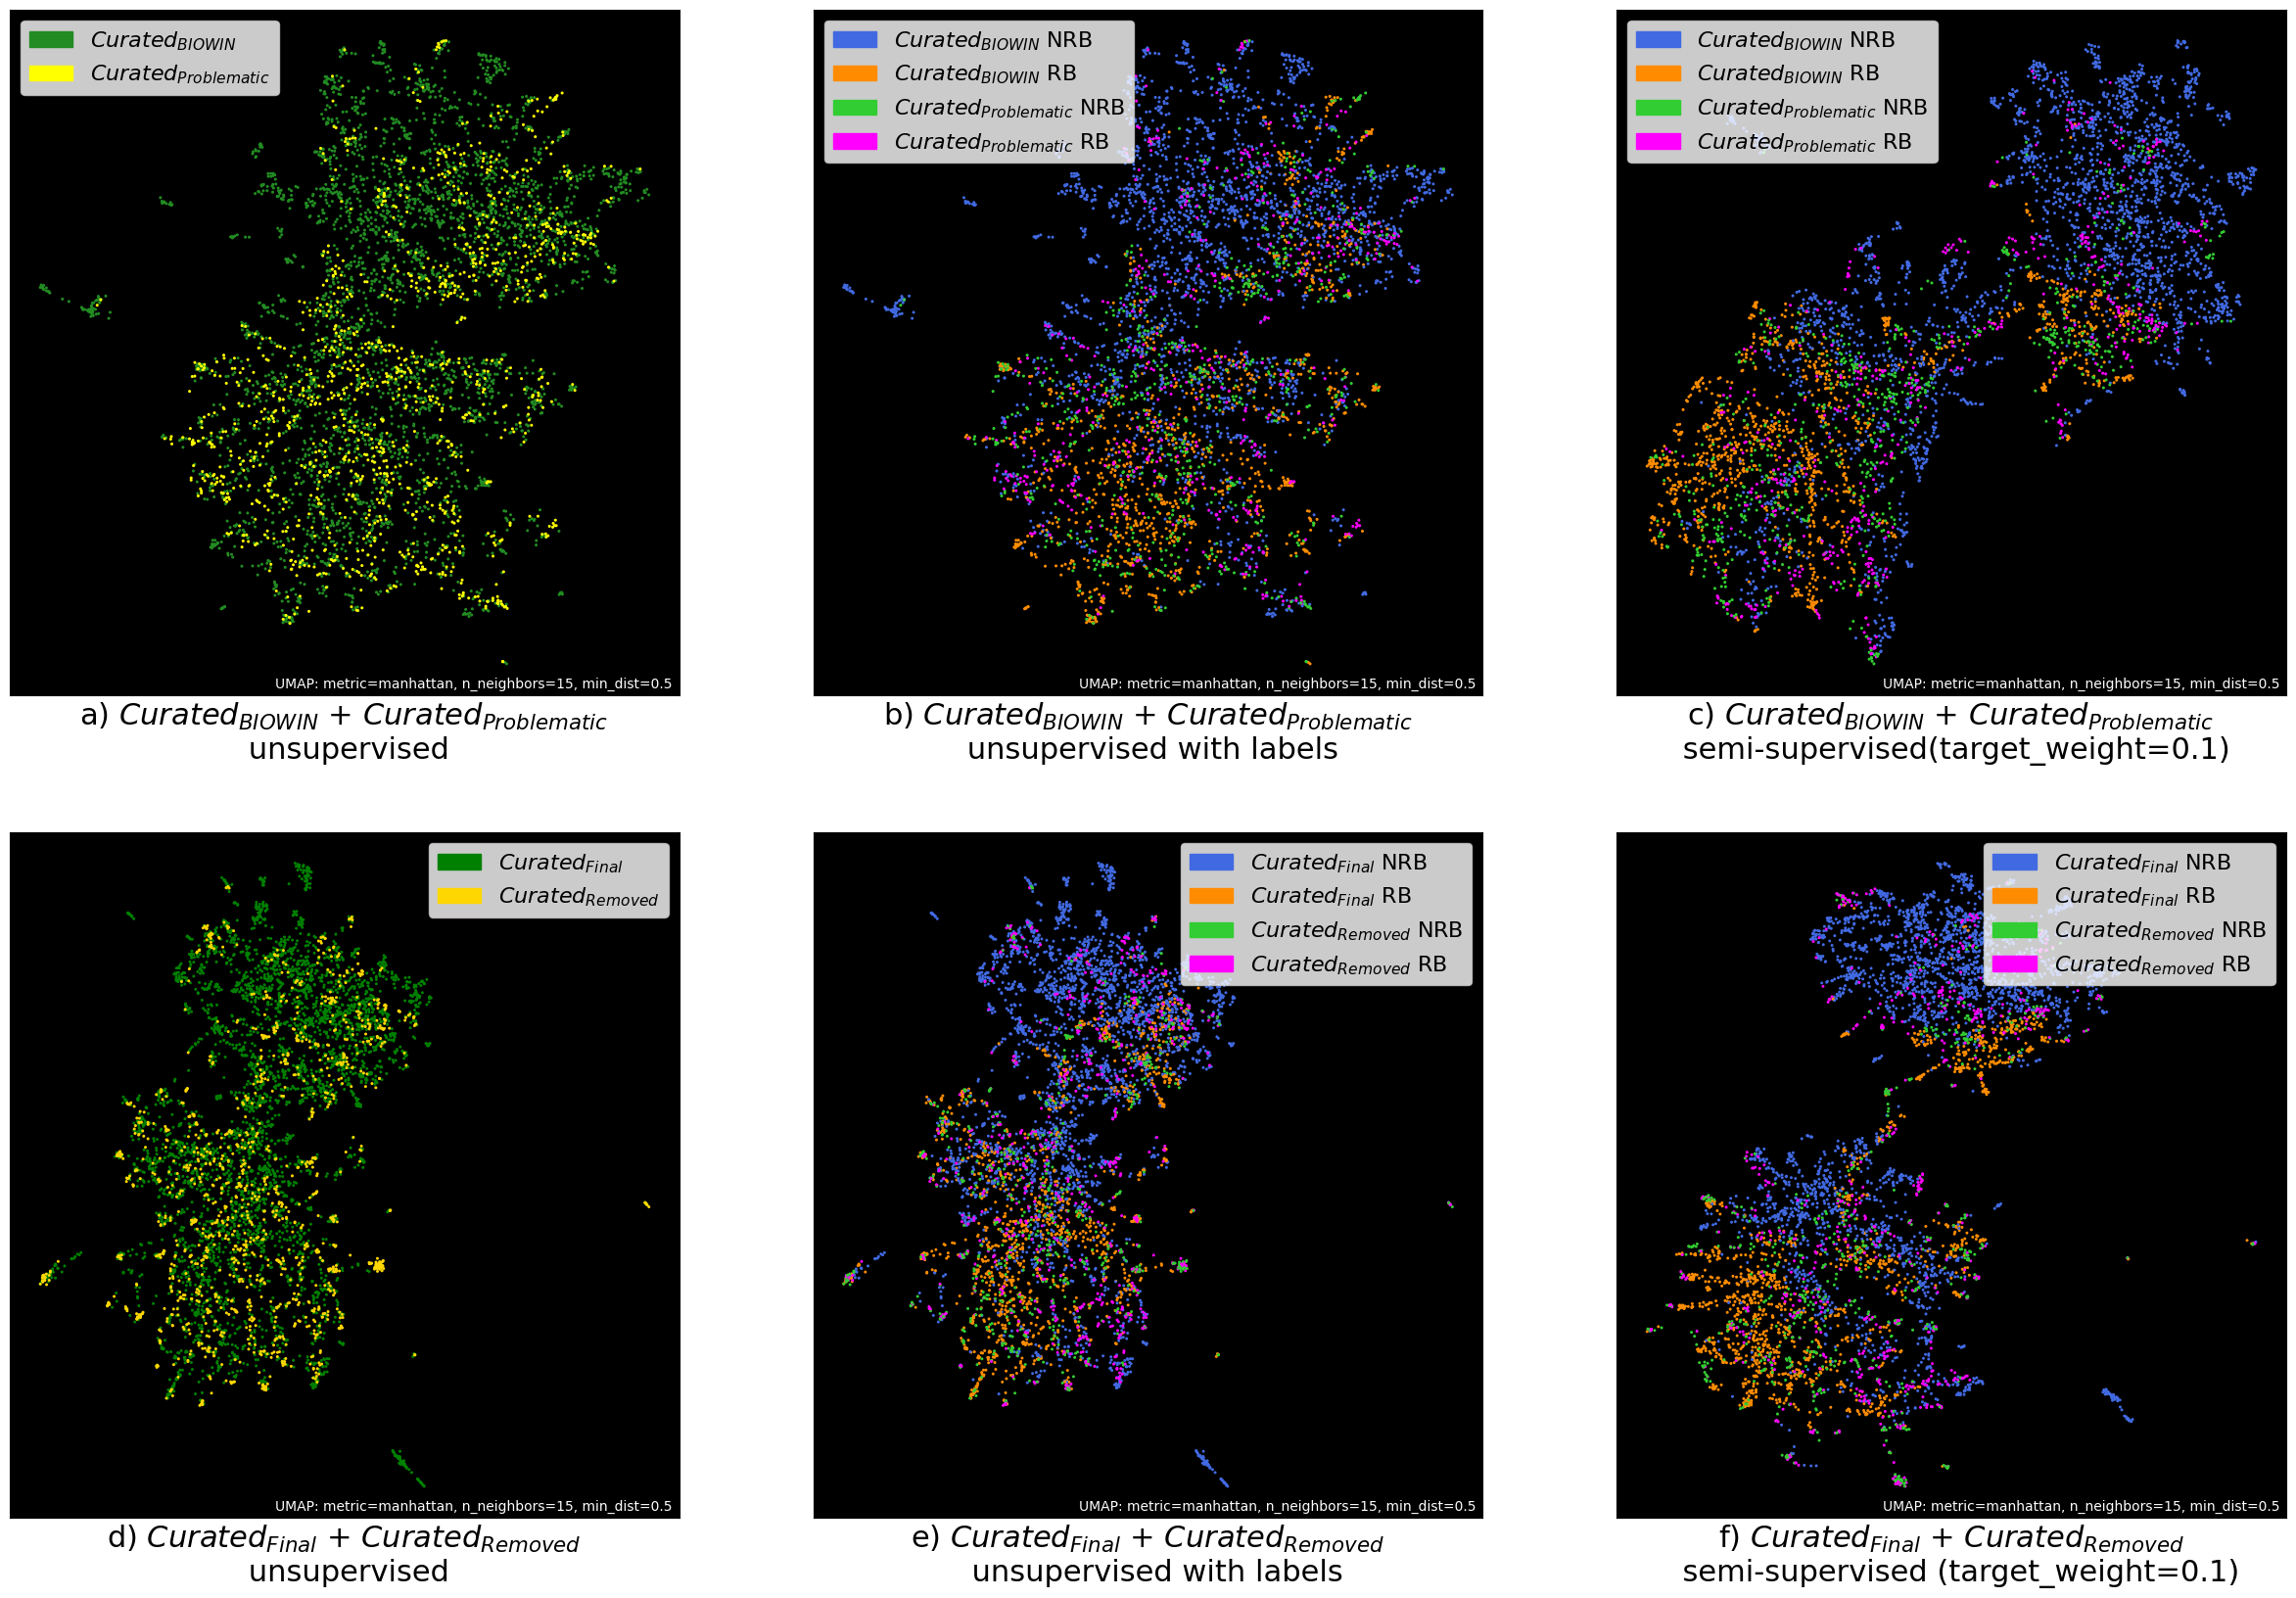

In [5]:
create_plot_umap_semisupervised(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.5, 
    target_weight=0.1, 
    metric="manhattan", 
    random_state=42,
    feature_type="RDK",
    legend_loc=[
        'upper left',
        'upper left',
        'upper left',
        'upper right',
        'upper right',
        'upper right',
    ],
)

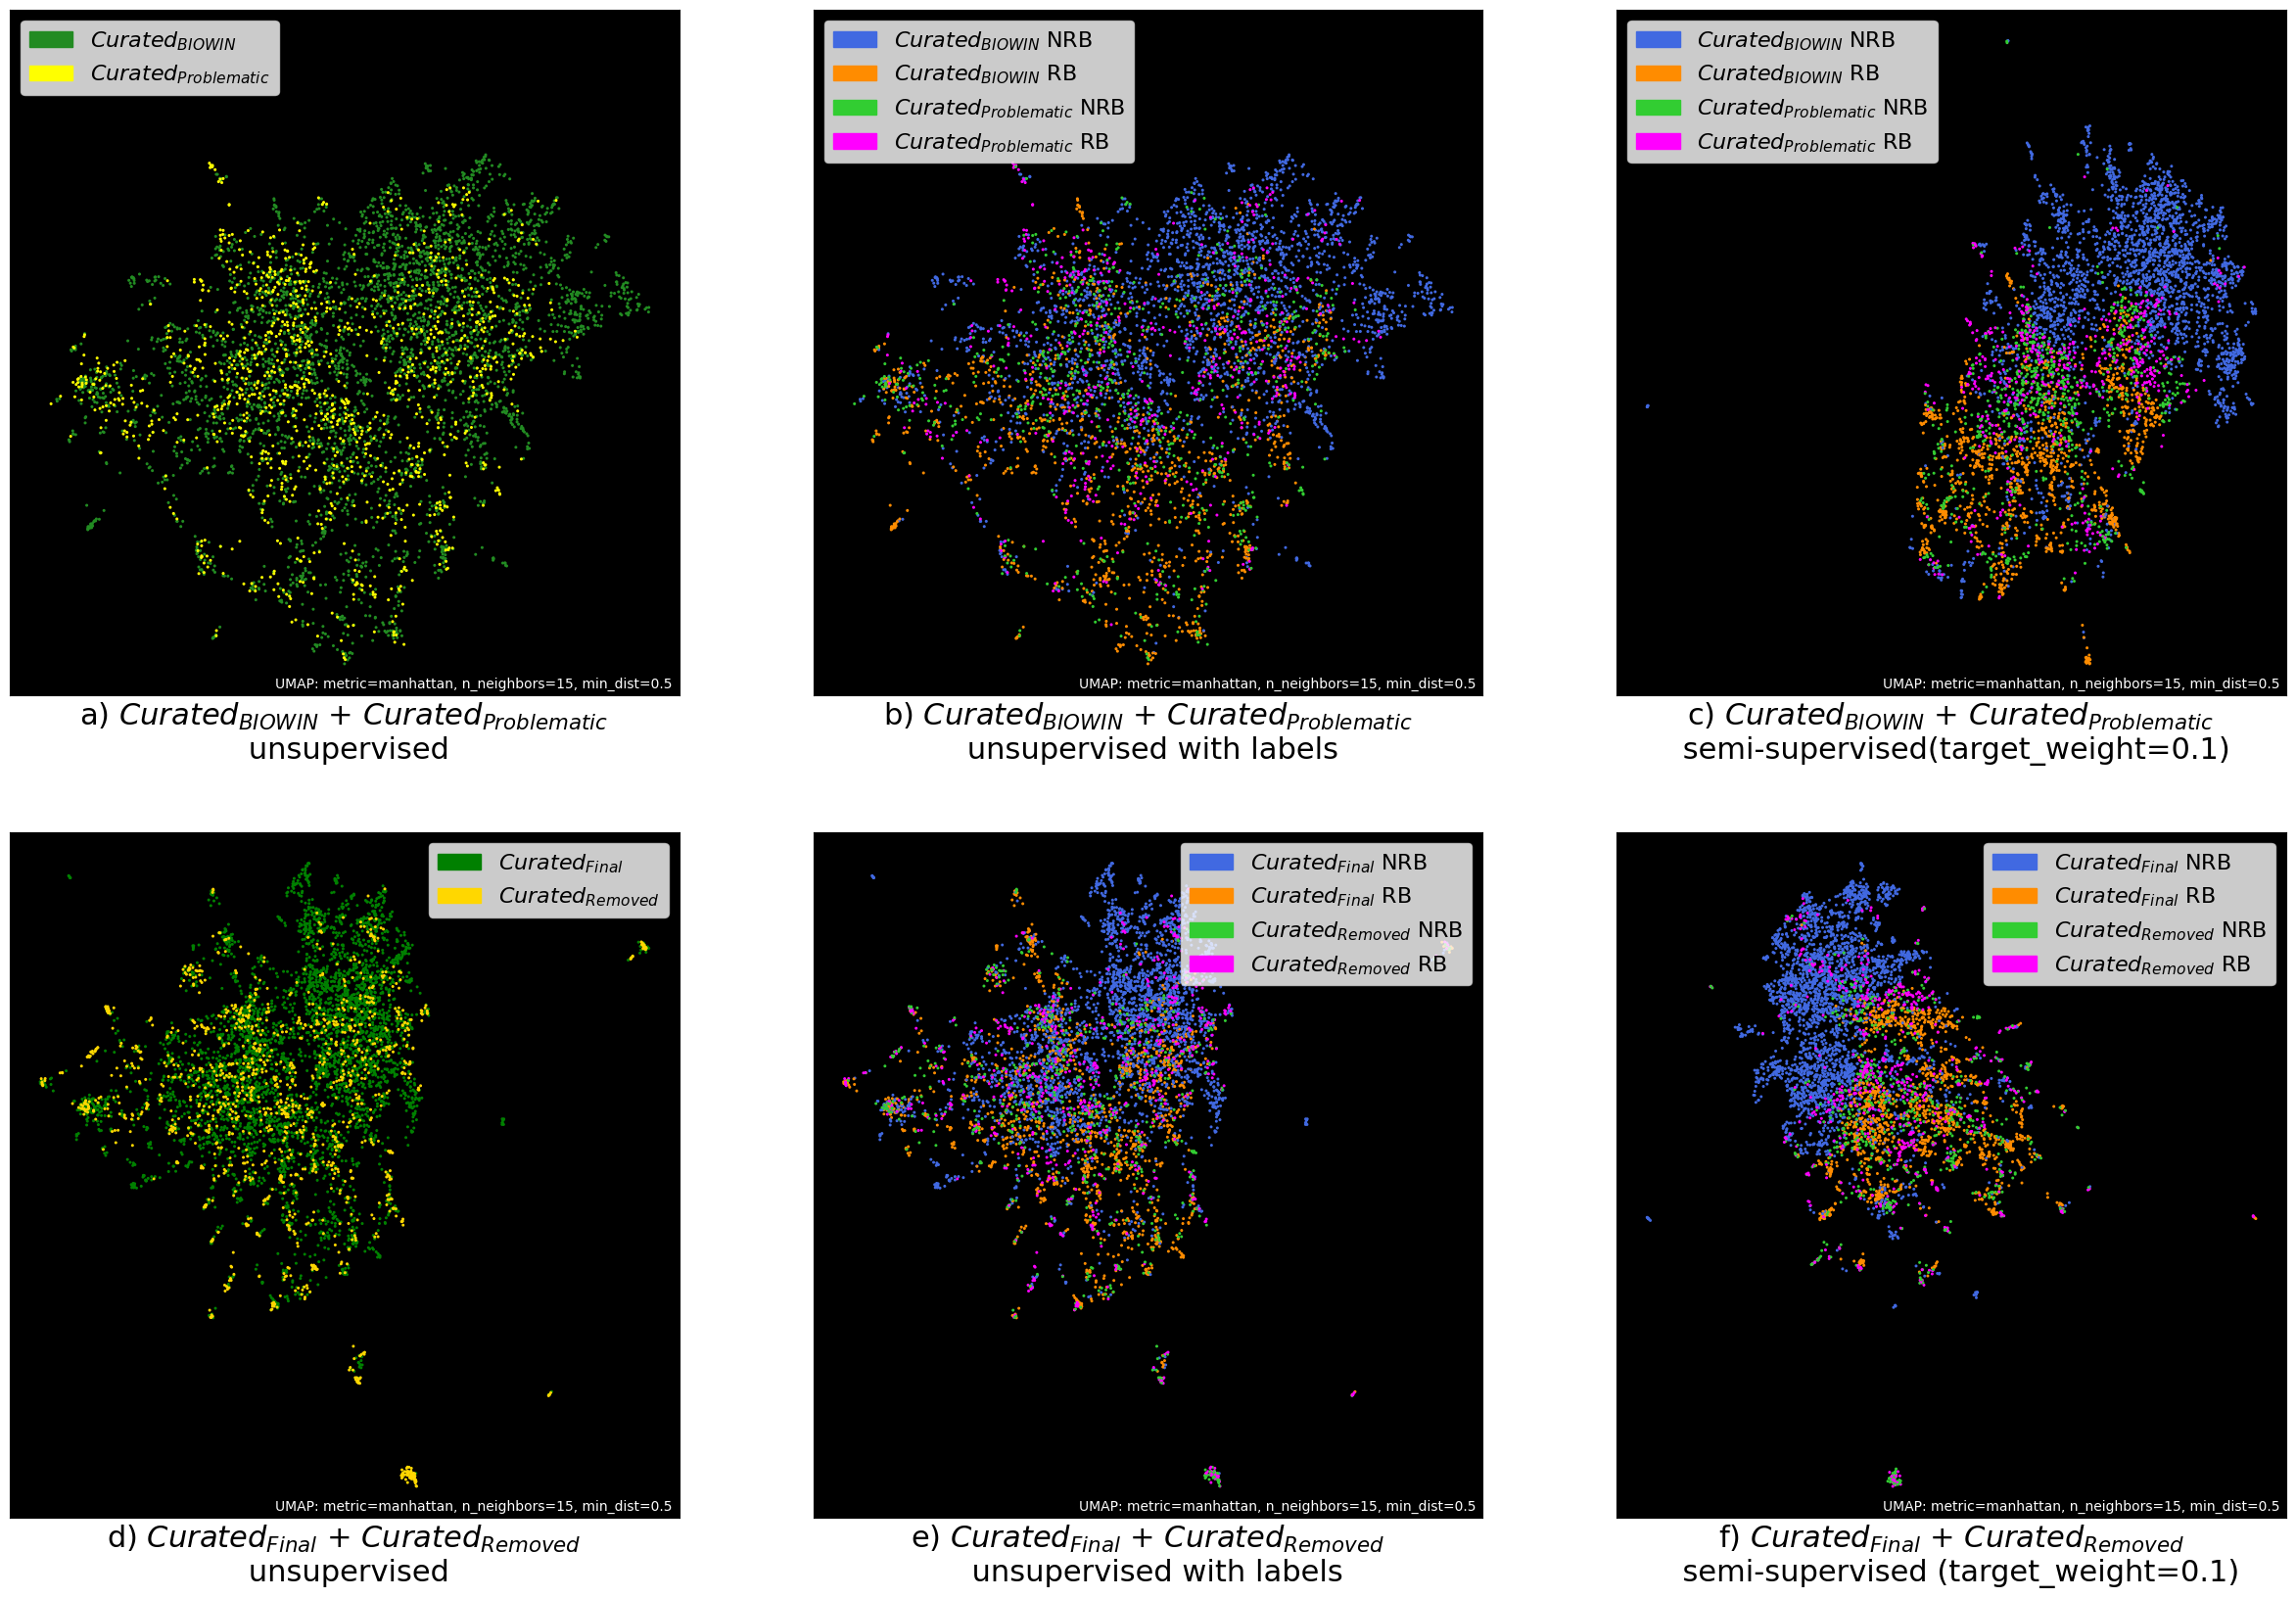

In [6]:
create_plot_umap_semisupervised(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.5, 
    target_weight=0.1, 
    metric="manhattan", 
    random_state=42,
    feature_type="Morgan",
    legend_loc=[
        'upper left',
        'upper left',
        'upper left',
        'upper right',
        'upper right',
        'upper right',
    ],
)

Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345


Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345


Using Rotation Embedding
Using Rotation Embedding


Getting embeddings from MolFormer:   0%|                                   | 0/3775 [00:00<?, ?it/s]/Users/paulina_koerner/Desktop/MasterThesis/molformer_venv/lib/python3.11/site-packages/fast_transformers/feature_maps/fourier_features.py:37: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2432.)
  Q, _ = torch.qr(block)
Getting embeddings from MolFormer: 100%|████████████████████████| 1296/1296 [02:59<00:00,  7.21it/s]


Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345


Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345


Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Getting embeddings from MolFormer: 100%|████████████████████████| 1341/1341 [02:04<00:00, 10.76it/s]


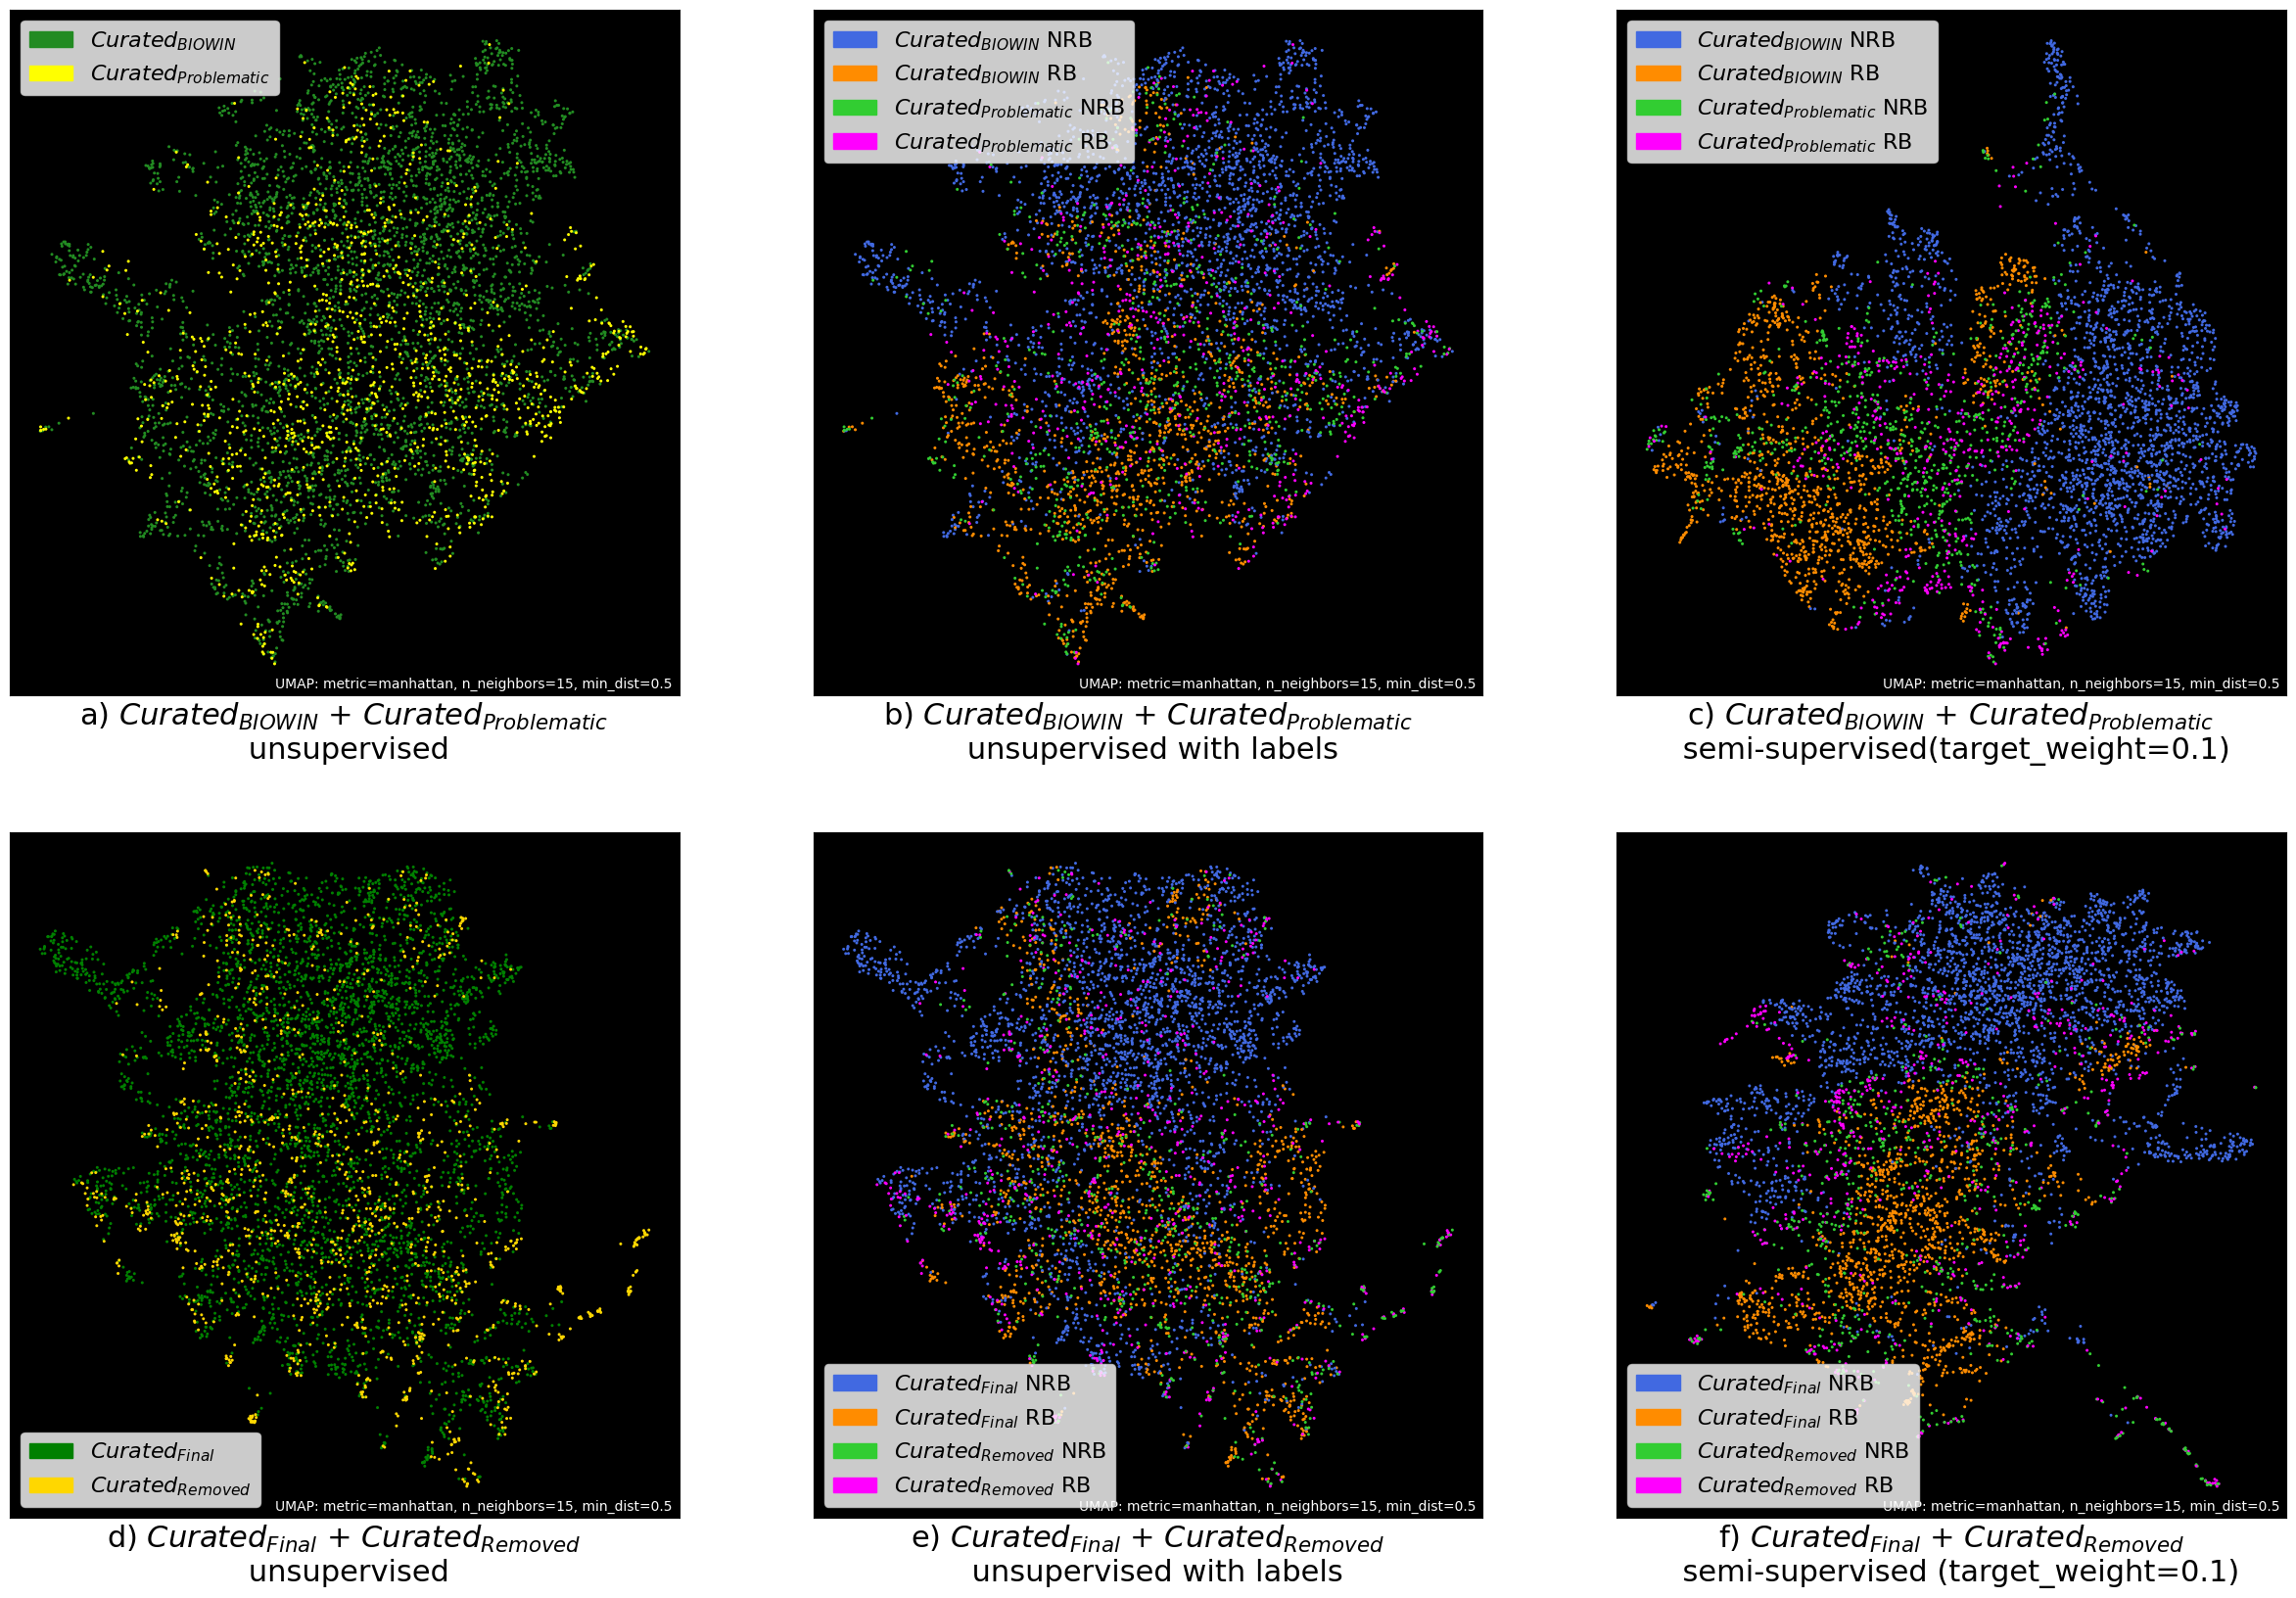

In [7]:
create_plot_umap_semisupervised(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.5, 
    target_weight=0.1, 
    metric="manhattan", 
    random_state=42,
    feature_type="Molformer",
    legend_loc=[
        'upper left',
        'upper left',
        'upper left',
        'lower left',
        'lower left',
        'lower left',
    ],
)

# Create TOC

In [26]:
df_removed_labels_final, df_all_final, df_four_labels_final, df_four_colors_final, df_fp_labeled_final, df_semi_supervised_final, df_removed_labeled = create_dfs_final_umap(feature_type="MACCS")


In [18]:
def create_plot_toc(
    n_components, 
    n_neighbors, 
    min_dist, 
    target_weight, 
    metric, 
    random_state,
    feature_type,
    legend_loc,
) -> None:

    df_removed_labels_final, df_all_final, df_four_labels_final, df_four_colors_final, df_fp_labeled_final, df_semi_supervised_final, df_removed_labeled = create_dfs_final_umap(feature_type="MACCS")

    manifold_all_us, y_all_us = create_manifold(
        df=df_all_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )

    manifold_all, y_all = create_manifold(
        df=df_all_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=True,
    )
    manifold_final, y_final_str = create_manifold(
        df=df_fp_labeled_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=True,
    )

    x, y, y_str_removed = df_removed_labeled.drop(["label", "label_str"], axis=1), df_removed_labeled[["label"]].values.flatten(), df_removed_labeled[["label_str"]].values.flatten()
    manifold_removed = manifold_final.transform(x)

    # Create plot
    manifolds = [
        manifold_all_us.embedding_,
        manifold_all.embedding_,
        manifold_final.embedding_,
        manifold_removed, 
    ]
    y_strs = [
        y_all_us,
        y_all,
        y_final_str,
        y_str_removed,
    ]

    titles = [
        "$Curated_{SCS}$ unsupervised",
        "$Curated_{SCS}$",
        "$Curated_{Final}$",
        "$Curated_{Removed}$",
    ]

    fig, axs = plt.subplots(4, 1, figsize=(10, 40))
    for i, ax in enumerate(axs.flatten()):
        color = ['blue' if l == "$Curated_{Final}$ NRB" else 'orange' for l in y_strs[i]]


        manifold = manifolds[i]
        ax.scatter(manifold[:, 0], manifold[:, 1], s=16, c=color)
        ax.set_title(titles[i], fontsize=32)
        ax.set_facecolor('black')
        nrb = mpatches.Patch(color='blue', label="NRB")
        rb = mpatches.Patch(color='orange', label="RB")
        ax.legend(loc=legend_loc[i], handles=[nrb, rb], fontsize=22)


/Users/paulina_koerner/Desktop/MasterThesis/molformer_venv/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


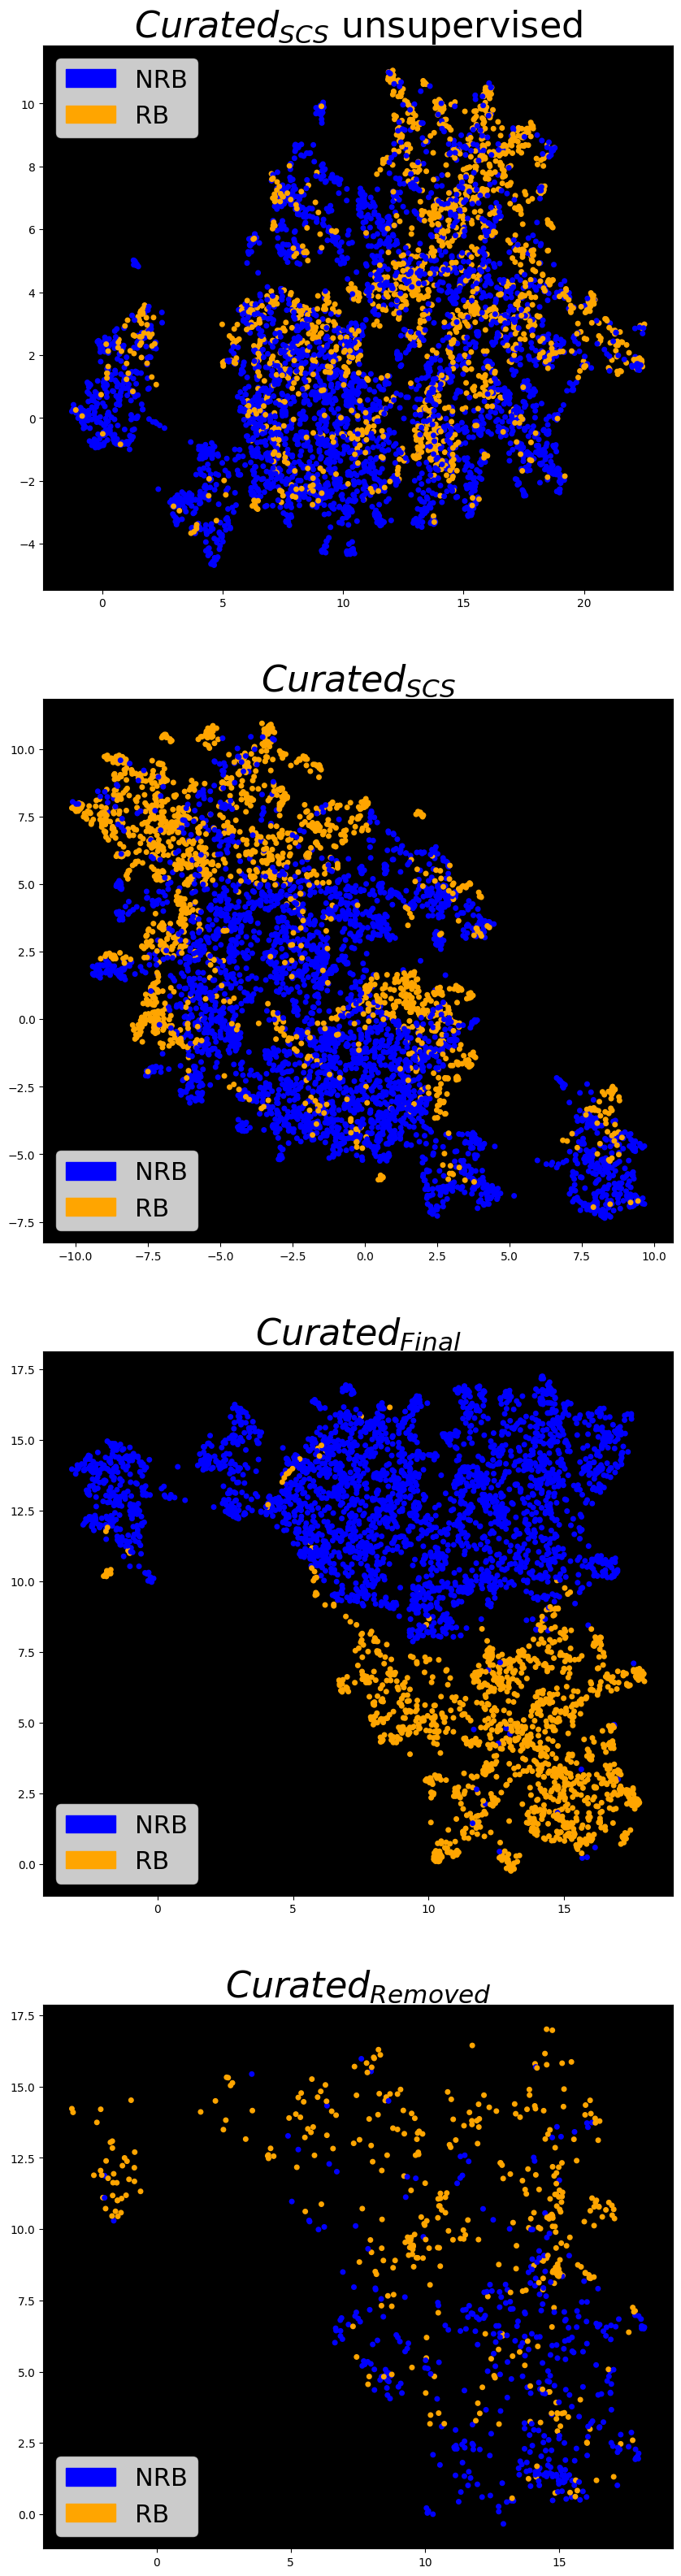

In [19]:
create_plot_toc(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.5, 
    target_weight=0.1, 
    metric="manhattan", 
    random_state=42,
    feature_type="MACCS",
    legend_loc=[
        'upper left',
        'lower left',
        'lower left',
        'lower left',
    ],
)

In [41]:
# All unsupervised
df_all_final.reset_index(inplace=True, drop=True)
x, y, y_str = df_all_final.drop(["label", "label_str"], axis=1), df_all_final[["label"]].values.flatten(), df_all_final[["label_str"]].values.flatten()
y_encoded = pd.factorize(y)[0]

embedding_all = umap.UMAP(
    n_neighbors=15,
    min_dist=0.3,
    metric='manhattan',
    n_components=3,
    random_state=42,
    target_weight=0.1,
).fit(x, y_encoded)

df = pd.DataFrame(embedding_all.transform(x), columns=['x', 'y', 'z'])
df['label_str'] = df_all_final['label_str']

curated = "$Curated_{Final}$"
removed = "$Curated_{Removed}$"

color_key={
    f"{curated} NRB": 'royalblue', 
    f"{removed} NRB": 'forestgreen', 
    f"{curated} RB": 'orange', 
    f"{removed} RB": 'fuchsia'} 

fig = px.scatter_3d(
        df, 
        x='x', 
        y='y', 
        z='z',
        color='label_str',
        template='plotly_white', # plotly_dark, plotly_white
        color_discrete_map=color_key,
        width=900,
        height=700,
)
fig.update_layout()
fig.update_traces(marker_size=3)

/Users/paulina_koerner/Desktop/MasterThesis/molformer_venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [42]:
# Final supervised
df_fp_labeled_final.reset_index(inplace=True, drop=True)
x, y, y_str = df_fp_labeled_final.drop(["label", "label_str"], axis=1), df_fp_labeled_final[["label"]].values.flatten(), df_fp_labeled_final[["label_str"]].values.flatten()
y_encoded = pd.factorize(y)[0]

embedding_final = umap.UMAP(
    n_neighbors=15,
    min_dist=0.3,
    metric='manhattan',
    n_components=3,
    random_state=42,
    target_weight=0.1,
).fit(x, y_encoded)

df = pd.DataFrame(embedding_final.transform(x), columns=['x', 'y', 'z'])
df['label_str'] = df_fp_labeled_final['label_str']

curated = "$Curated_{Final}$"
removed = "$Curated_{Removed}$"

color_key={
    f"{curated} NRB": 'royalblue', 
    f"{removed} NRB": 'forestgreen', 
    f"{curated} RB": 'orange', 
    f"{removed} RB": 'fuchsia'} 

fig = px.scatter_3d(
        df, 
        x='x', 
        y='y', 
        z='z',
        color='label_str',
        template='plotly_white', # plotly_dark, plotly_white
        color_discrete_map=color_key,
        width=900,
        height=700,
)
fig.update_layout()
fig.update_traces(marker_size=3)

/Users/paulina_koerner/Desktop/MasterThesis/molformer_venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [43]:
# removed transformed
df_removed_labeled.reset_index(inplace=True, drop=True)
x, y, y_str = df_removed_labeled.drop(["label", "label_str"], axis=1), df_removed_labeled[["label"]].values.flatten(), df_removed_labeled[["label_str"]].values.flatten()
y_encoded = pd.factorize(y)[0]

df = pd.DataFrame(embedding_final.transform(x), columns=['x', 'y', 'z'])
df['label_str'] = df_removed_labeled['label_str']

curated = "$Curated_{Final}$"
removed = "$Curated_{Removed}$"

color_key={
    f"{curated} NRB": 'royalblue', 
    f"{removed} NRB": 'forestgreen', 
    f"{curated} RB": 'orange', 
    f"{removed} RB": 'fuchsia'} 

fig = px.scatter_3d(
        df, 
        x='x', 
        y='y', 
        z='z',
        color='label_str',
        template='plotly_white', # plotly_dark, plotly_white
        color_discrete_map=color_key,
        width=900,
        height=700,
)
fig.update_layout()
fig.update_traces(marker_size=3)

/Users/paulina_koerner/Desktop/MasterThesis/molformer_venv/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [77]:
prob = pd.read_csv("datasets/curated_data/class_curated_final_removed.csv", index_col=0)
print(len(prob))
print(len(prob[prob["label"] == 1]))
print(len(prob[prob["label"] == 0]))


808
402
406
